In [1]:
library(Seurat)
library(data.table)
library(ggplot2)
library(plyr)
library(ggridges)


Lade n"otiges Paket: SeuratObject

Lade n"otiges Paket: sp



'SeuratObject' was built under R 4.3.1 but the current version is
4.3.2; it is recomended that you reinstall 'SeuratObject' as the ABI
for R may have changed

'SeuratObject' was built with package 'Matrix' 1.6.3 but the current
version is 1.6.4; it is recomended that you reinstall 'SeuratObject' as
the ABI for 'Matrix' may have changed


Attache Paket: 'SeuratObject'


Das folgende Objekt ist maskiert 'package:base':

    intersect




In [2]:
library(extrafont)
font_import(paths = "/Library/Fonts", prompt = FALSE)
loadfonts()
fonts()


Registering fonts with R

Scanning ttf files in /Library/Fonts ...

Extracting .afm files from .ttf files...

/System/Library/Fonts/Supplemental/Arial Unicode.ttf


 : ArialUnicodeMS already registered in fonts database. Skipping.

/Library/Fonts/FontsFree-Net-MYRIADPRO-REGULAR.ttf
 : MyriadPro-Regular already registered in fonts database. Skipping.

Found FontName for 0 fonts.

Scanning afm files in /Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/library/extrafontdb/metrics

Arial Unicode MS already registered with pdfFont().

Myriad Pro already registered with pdfFont().

Arial Unicode MS already registered with postscriptFont().

Myriad Pro already registered with postscriptFont().



[1] "Arial Unicode MS" "Myriad Pro"

In [3]:
plot_theme <- function() {
  theme_bw() + theme(
    panel.border = element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    text = element_text(size = 24, family = "Myriad Pro"),
    axis.text = element_text(size = 26),
    axis.title = element_text(size = 30),
    legend.text = element_text(size = 24),
    legend.title = element_text(size = 26),
    legend.key.size = unit(0.8, "cm"),
    plot.title = element_text(size = 30, hjust = 0.5),
    axis.line = element_line(linewidth = 0.7, colour = "black"),
    plot.margin = margin(
      t = 1,
      b = 0.1,
      r = 0.3,
      l = 0.6,
      "cm"
    )
  )
}
options(repr.plot.width = 10, repr.plot.height = 9)


## Visualisation of HTODemux result

### UMAP plot


In [4]:
# Load htodemux result from an rds object
htodemux_gx38 <-
    readRDS("../data/pipeline_output/gx38/htodemux.rds")
# Rename features
htodemux_gx38@assays$HTO@counts@Dimnames[[1]] <-
    paste0("Hash45", 1:6)
rownames(htodemux_gx38@assays$HTO@data) <- paste0("Hash45", 1:6)
rownames(htodemux_gx38@assays$HTO@meta.features) <-
    paste0("Hash45", 1:6)
htodemux_gx38 <- RenameIdents(
    htodemux_gx38,
    "Hash453-TotalSeqA" = "Hash453",
    "Hash451-TotalSeqA" = "Hash451",
    "Hash452-TotalSeqA" = "Hash452",
    "Hash454-TotalSeqA" = "Hash454",
    "Hash455-TotalSeqA" = "Hash455",
    "Hash456-TotalSeqA" = "Hash456"
)

# Subset the object, remove negative droplets
htodemux_gx38_subset <- subset(htodemux_gx38,
    idents = "Negative", invert = TRUE
)

# Calculate a UMAP embedding of the HTO data
DefaultAssay(htodemux_gx38_subset) <- "HTO"
htodemux_gx38_subset <- ScaleData(
    htodemux_gx38_subset,
    features = rownames(htodemux_gx38_subset),
    verbose = FALSE
)
htodemux_gx38_subset <- RunPCA(
    htodemux_gx38_subset,
    features = rownames(htodemux_gx38_subset),
    approx = FALSE
)
htodemux_gx38_subset <- RunUMAP(htodemux_gx38_subset, dims = 1:6)


Warning message:
"Requested number is larger than the number of available items (6). Setting to 6."
Warning message:
"Requested number is larger than the number of available items (6). Setting to 6."
Warning message:
"Requested number is larger than the number of available items (6). Setting to 6."
Warning message:
"Requested number is larger than the number of available items (6). Setting to 6."
Warning message:
"Requested number is larger than the number of available items (6). Setting to 6."
PC_ 1 
Positive:  Hash454, Hash451, Hash455 
Negative:  Hash452, Hash456, Hash453 
PC_ 2 
Positive:  Hash456, Hash455, Hash453 
Negative:  Hash451, Hash452, Hash454 
PC_ 3 
Positive:  Hash451, Hash456, Hash455 
Negative:  Hash452, Hash454, Hash453 
PC_ 4 
Positive:  Hash456, Hash452, Hash454 
Negative:  Hash455, Hash453, Hash451 
PC_ 5 
Positive:  Hash453, Hash456, Hash454 
Negative:  Hash455, Hash452, Hash451 

Warning message:
"The default method for RunUMAP has changed from calling Python UMA

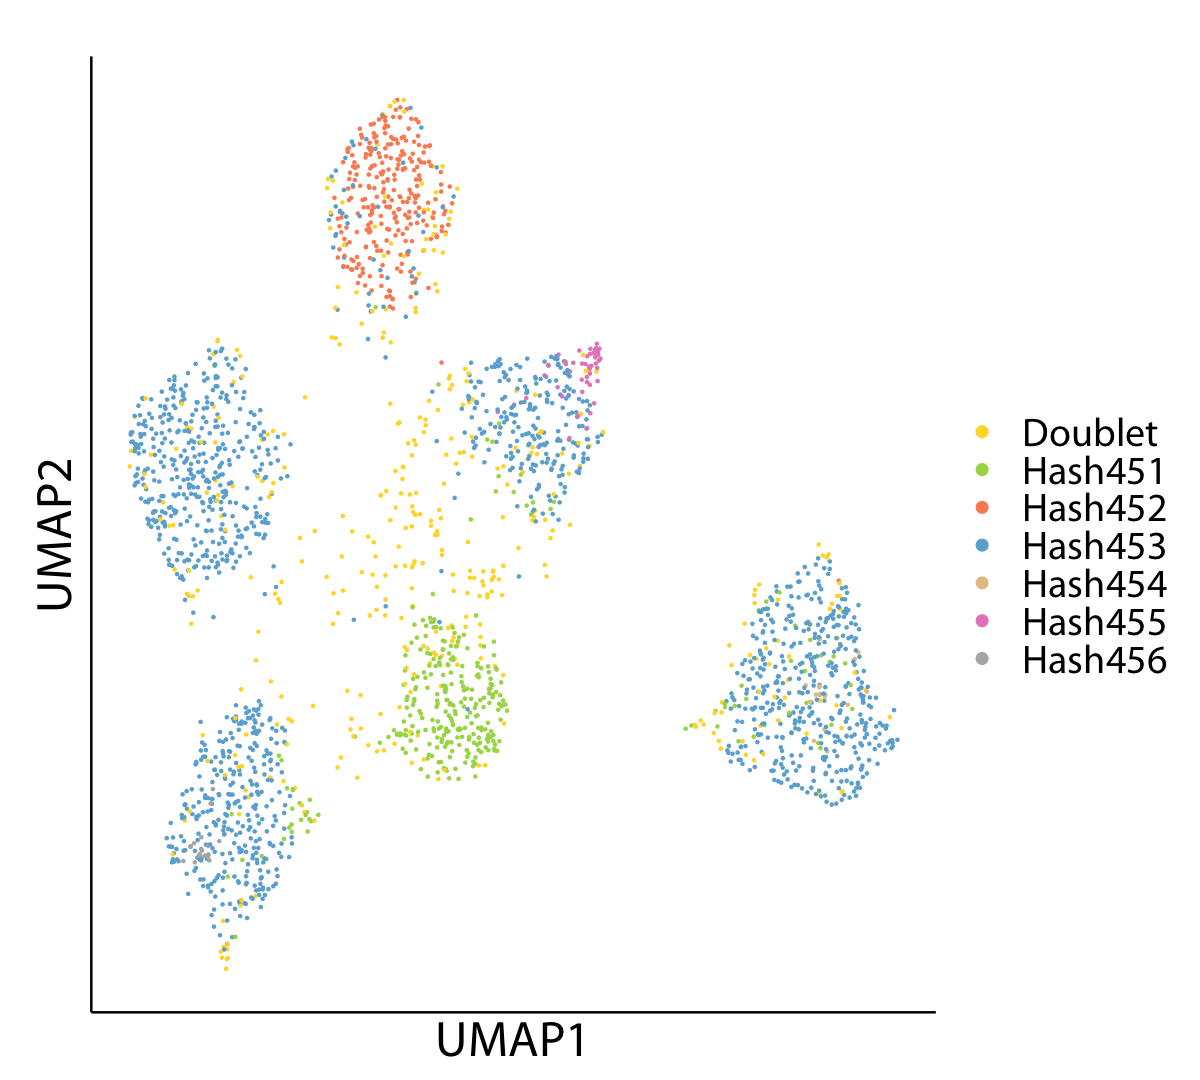

In [5]:
DimPlot(htodemux_gx38_subset, reduction = "umap") +
  scale_colour_manual(
    values = c(
      "#FFD92F",
      "#A6D854",
      "#FC8D62",
      "#6BAED6",
      "#E5C494",
      "#E78AC3",
      "#B3B3B3"
    ),
    limits = c("Doublet", paste0("Hash45", 1:6)),
    labels = c("Doublet", paste0("Hash45", 1:6))
  ) +
  plot_theme() + xlab("UMAP1") + ylab("UMAP2") + theme(
    axis.text.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.text.y = element_blank(),
    axis.ticks.y = element_blank()
  )


### Ridge plot


In [6]:
rp <- RidgePlot(
    htodemux_gx38,
    assay = "HTO",
    idents = paste0("Hash45", 1:6),
    features = paste0("Hash45", 1:6),
    ncol = 3,
    cols = c(
        "#6BAED6",
        "#A6D854",
        "#FC8D62",
        "#E5C494",
        "#E78AC3",
        "#B3B3B3"
    )
)
for (i in 1:6) {
    rp[[i]] <-
        rp[[i]] + theme_ridges(font_size = 20, font_family = "Myriad Pro") +
        theme(legend.position = "none") + ylab("")
}


Picking joint bandwidth of 0.0301

Picking joint bandwidth of 0.0299

Picking joint bandwidth of 0.0316

Picking joint bandwidth of 0.0302

Picking joint bandwidth of 0.057

Picking joint bandwidth of 0.0423



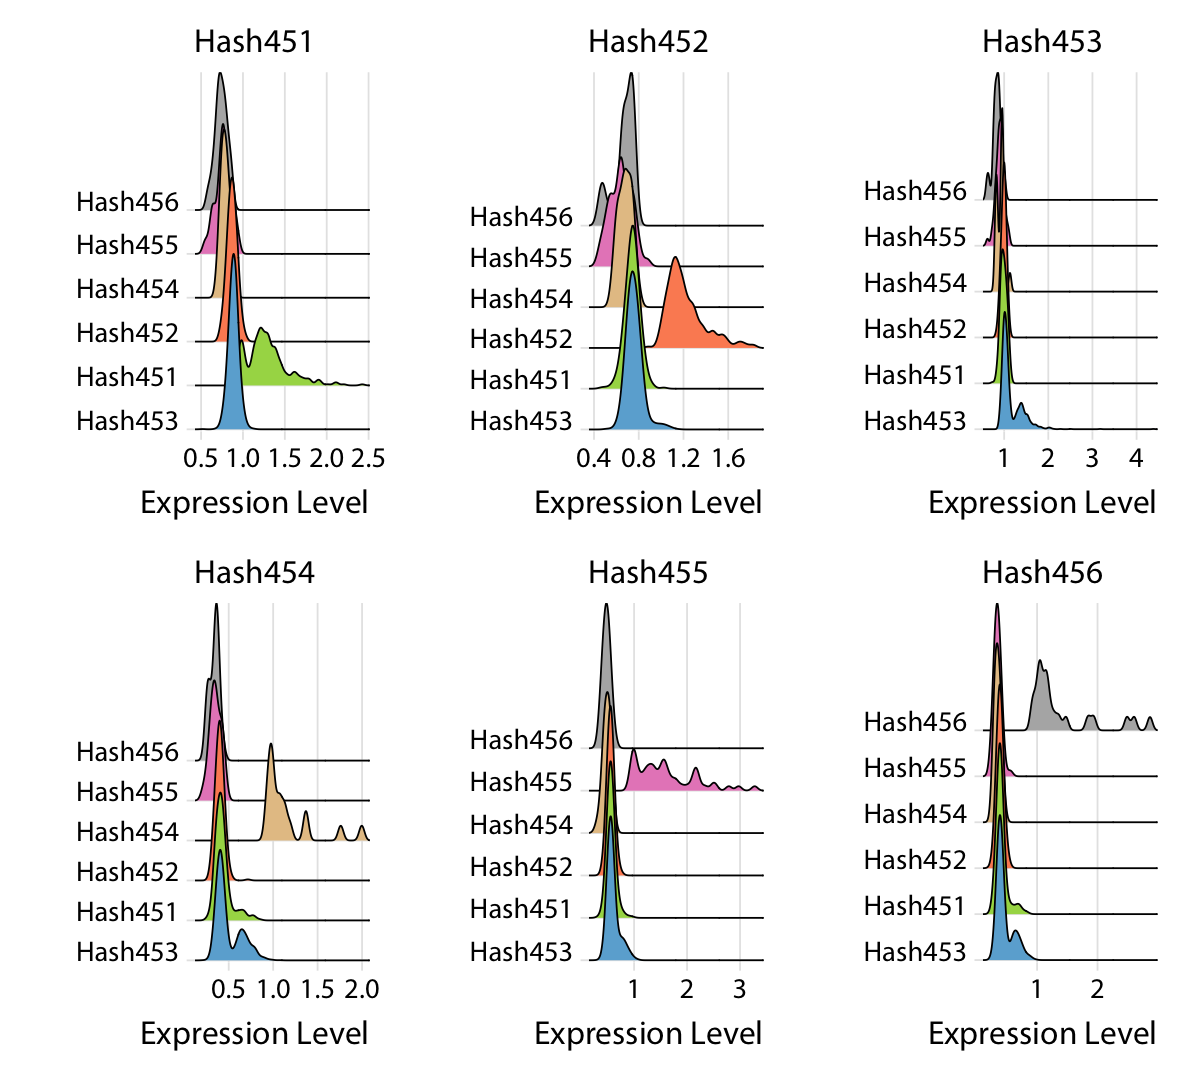

In [7]:
rp
# ggsave("s6/ridge_gx38.pdf", dpi = 300, height = 9, width = 10)


### Heatmap


Warning message:
"The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.
i The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>."
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


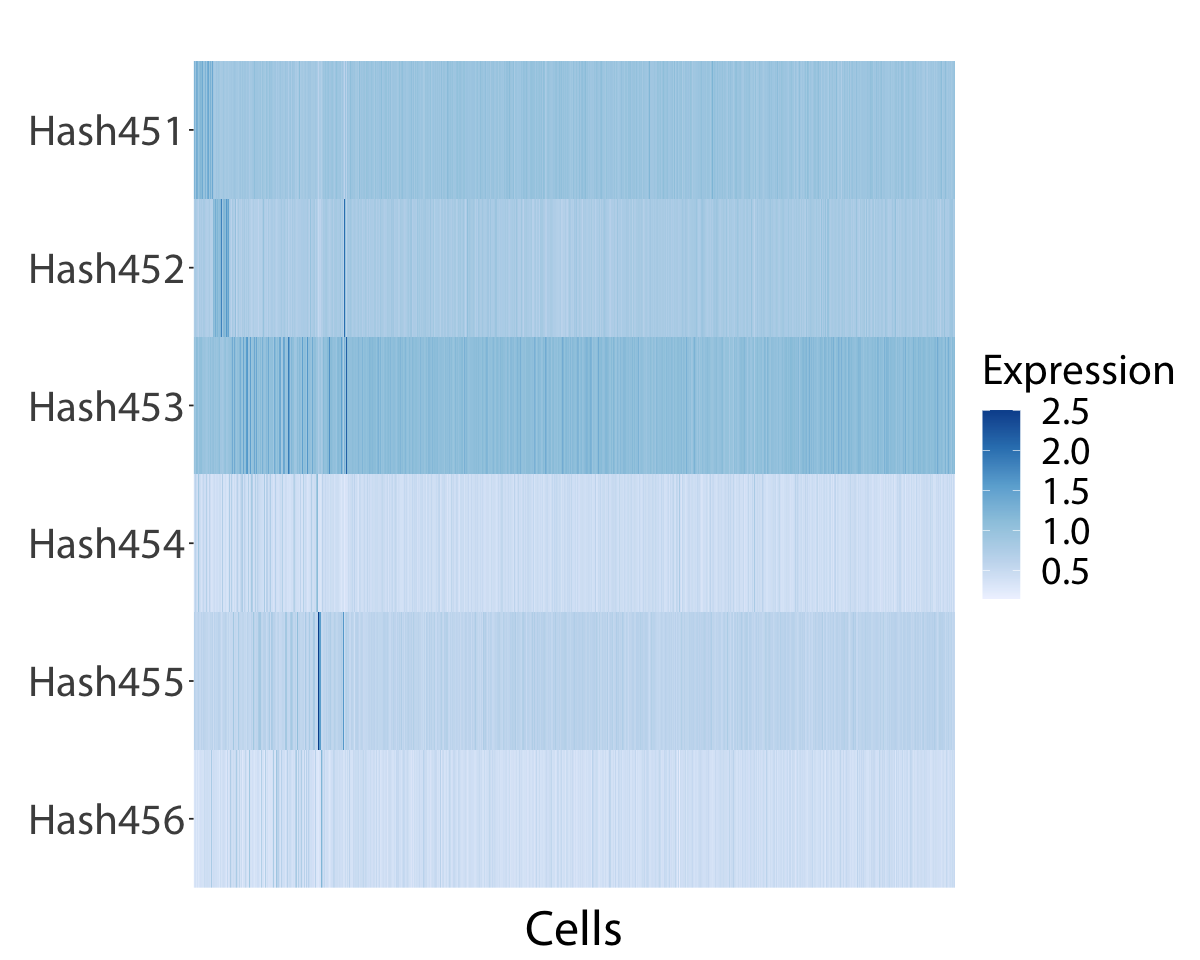

In [8]:
options(repr.plot.width = 10, repr.plot.height = 8)
htodemux_gx38@meta.data$HTO_classification <-
  gsub("-TotalSeqA", "", htodemux_gx38@meta.data$HTO_classification)

HTOHeatmap(htodemux_gx38, assay = "HTO", ncells = 12585) +
  scale_fill_gradientn(colors = RColorBrewer::brewer.pal(n = 6, name = "Blues")) +
  xlab("Cells") +
  theme_bw() + theme(
    panel.border = element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    text = element_text(size = 24, family = "Myriad Pro"),
    axis.text = element_text(size = 26),
    axis.title = element_text(size = 30),
    axis.ticks.x = element_blank(),
    axis.text.x = element_blank(),
    legend.text = element_text(size = 24),
    legend.title = element_text(size = 26),
    legend.key.size = unit(0.8, "cm"),
    plot.title = element_text(size = 30, hjust = 0.5),
    plot.margin = margin(
      t = 1,
      b = 0.1,
      r = 0.3,
      l = 0.6,
      "cm"
    )
  )
# ggsave(
#   "s6/heatmap_gx38.pdf",
#   dpi = 300,
#   height = 8,
#   width = 10
# )


### Violin plot


In [9]:
# Raw counts
counts_raw <- t(as.matrix(htodemux_gx38[["HTO"]]@counts))
counts_raw <- melt(counts_raw)
colnames(counts_raw) <- c("Cell", "Hashtag", "Expression")
head(counts_raw)

cutoff <-
    data.frame(
        Hashtag = paste0("Hash45", 1:6),
        slope_value = c(233, 186, 287, 89, 119, 88)
    )
cutoff$Hashtag <- as.factor(cutoff$Hashtag)
cutoff


Warning message in melt(counts_raw):
"The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(counts_raw). In the next version, this warning will become an error."


,Cell,Hashtag,Expression
,<fct>,<fct>,<dbl>
1,AAACCCAAGGATGAGA-1,Hash451,166
2,AAACCCAAGGTACCTT-1,Hash451,170
3,AAACCCAAGTCATTGC-1,Hash451,166
4,AAACCCAAGTTGGAGC-1,Hash451,174
5,AAACCCACAAGGCTTT-1,Hash451,177
6,AAACCCACACACAGCC-1,Hash451,169


Hashtag,slope_value
<fct>,<dbl>
Hash451,233
Hash452,186
Hash453,287
Hash454,89
Hash455,119
Hash456,88


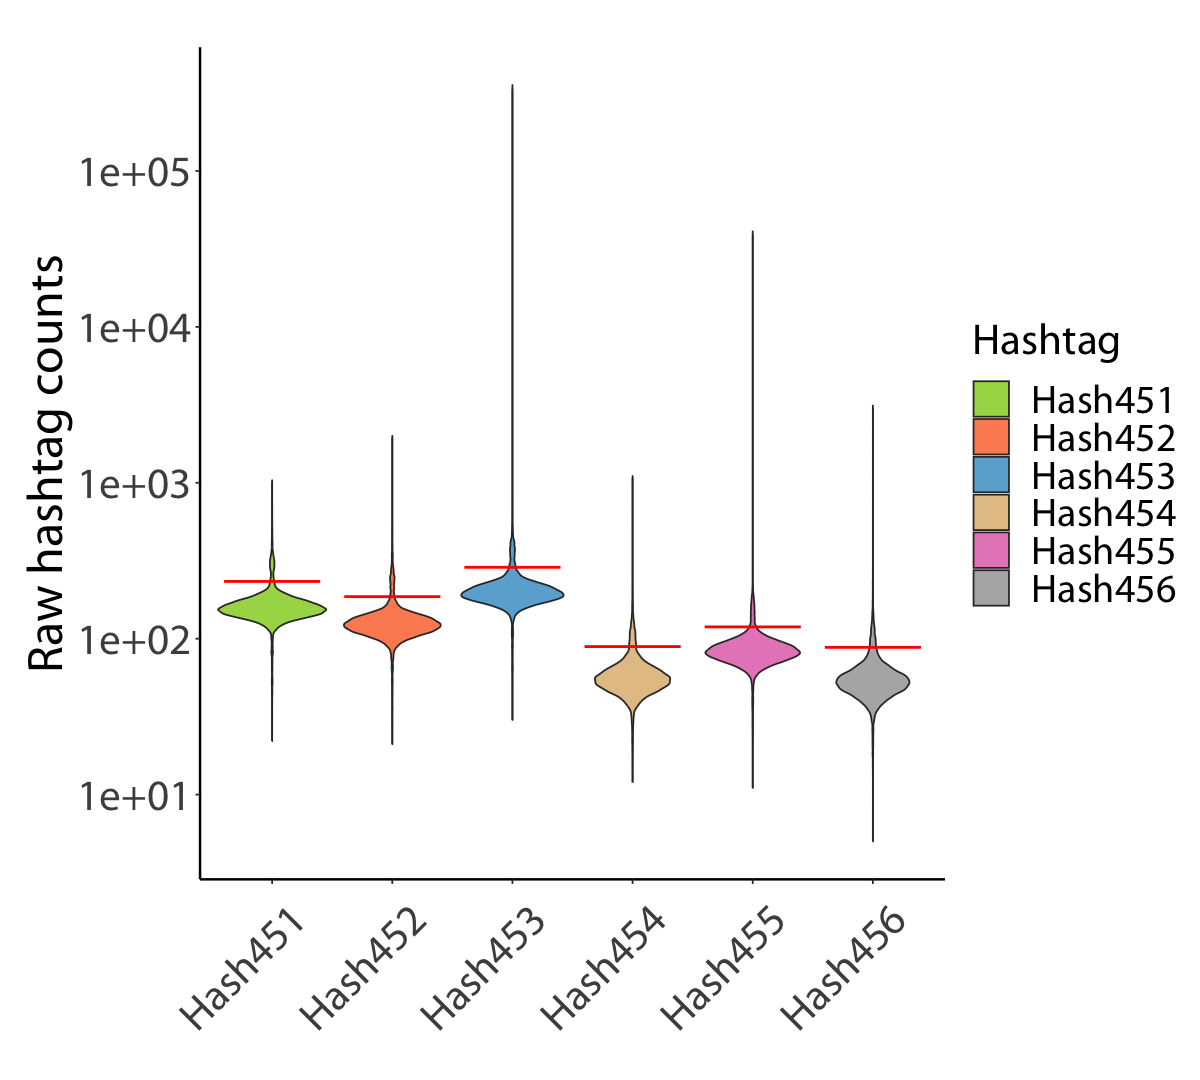

In [10]:
options(repr.plot.width = 10, repr.plot.height = 9)
ggplot(counts_raw) +
  geom_violin(aes(x = Hashtag, y = Expression, fill = Hashtag)) +
  xlab("") +
  ylab("Raw hashtag counts") +
  scale_fill_manual(values = c(
    "#A6D854",
    "#FC8D62",
    "#6BAED6",
    "#E5C494",
    "#E78AC3",
    "#B3B3B3"
  )) +
  geom_segment(
    data = cutoff,
    inherit.aes = FALSE,
    colour = "red",
    linewidth = 0.8,
    aes(
      x = as.numeric(Hashtag) - 0.4,
      xend = as.numeric(Hashtag) + 0.4,
      yend = slope_value,
      y = slope_value
    )
  ) +
  plot_theme() +
  scale_y_log10() +
  theme(axis.text.x = element_text(
    angle = 45,
    hjust = 0.8,
    vjust = 0.7
  ))


### Load hashing deconvolution results


In [11]:
# Load hashing deconvolution results
hash_gx38_classi <-
    fread("../data/pipeline_output/gx38/hash_classification_all.csv",
        na.strings = ""
    )
# Remove doublet detection method solo
hash_gx38_classi <- hash_gx38_classi[, -7]

# Remove the trial ID
colnames(hash_gx38_classi) <-
    c(
        "Barcode",
        "DemuxEM",
        "HashedDrops",
        "HashSolo",
        "HTODemux",
        "Multiseq",
        "GMM-Demux",
        "BFF"
    )

# Subset by only those cells detected by RNA
white_list_gx38 <-
    fread("../data/dataset/barcodes_gx38.tsv", header = FALSE)$V1
hash_gx38_classi <- hash_gx38_classi[Barcode %in% white_list_gx38, ]

head(hash_gx38_classi)


Barcode,DemuxEM,HashedDrops,HashSolo,HTODemux,Multiseq,GMM-Demux,BFF
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AAACCCAAGGATGAGA-1,negative,negative,doublet,negative,singlet,negative,doublet
AAACCCAAGGTACCTT-1,negative,negative,doublet,negative,negative,negative,doublet
AAACCCAAGTCATTGC-1,singlet,negative,doublet,negative,singlet,negative,doublet
AAACCCAAGTTGGAGC-1,singlet,negative,doublet,negative,singlet,negative,doublet
AAACCCACAAGGCTTT-1,negative,negative,doublet,negative,singlet,negative,doublet
AAACCCACACACAGCC-1,doublet,negative,doublet,singlet,doublet,negative,doublet


## Visualisation of hashing deconvolution results


In [12]:
# Reorder the result
summary_hash_gx38 <- melt(
    hash_gx38_classi,
    id.vars = "Barcode",
    variable.name = "Method",
    value.name = "Classification"
)
summary_hash_gx38 <- na.omit(summary_hash_gx38)
summary_hash_gx38 <- as.data.frame(table(summary_hash_gx38[, -1]))
colnames(summary_hash_gx38)[3] <- "Count"
summary_hash_gx38 <-
    summary_hash_gx38[order(summary_hash_gx38$Classification,
        decreasing = TRUE
    ), ]
head(summary_hash_gx38)


,Method,Classification,Count
,<fct>,<fct>,<int>
15,DemuxEM,singlet,5210
16,HashedDrops,singlet,97
17,HashSolo,singlet,1043
18,HTODemux,singlet,2124
19,Multiseq,singlet,7468
20,GMM-Demux,singlet,0


In [13]:
# Determine the y-axis position of labels ylab_pos
summary_hash_gx38_cumsum <- ddply(summary_hash_gx38,
    "Method",
    transform,
    label_ypos = cumsum(Count) - 0.5 * Count + 40
)

# Modify the ylab_pos manually
summary_hash_gx38_cumsum[summary_hash_gx38_cumsum$Method == "HashSolo" &
    summary_hash_gx38_cumsum$Classification == "negative", ]$label_ypos <-
    1300
summary_hash_gx38_cumsum[summary_hash_gx38_cumsum$Method == "HashedDrops" &
    summary_hash_gx38_cumsum$Classification == "singlet", ]$label_ypos <-
    300
summary_hash_gx38_cumsum[summary_hash_gx38_cumsum$Method == "HTODemux" &
    summary_hash_gx38_cumsum$Classification == "doublet", ]$label_ypos <-
    12410
summary_hash_gx38_cumsum[summary_hash_gx38_cumsum$Method == "BFF" &
    summary_hash_gx38_cumsum$Classification == "singlet", ]$label_ypos <-
    200
summary_hash_gx38_cumsum[summary_hash_gx38_cumsum$Method == "BFF" &
    summary_hash_gx38_cumsum$Classification == "negative", ]$label_ypos <-
    800

# Avoid showing count 0
summary_hash_gx38_cumsum[summary_hash_gx38_cumsum$Count == 0, ]$label_ypos <-
    NA

# Rename classification
library(stringr)
summary_hash_gx38_cumsum$Classification <-
    str_to_title(summary_hash_gx38_cumsum$Classification)

# Sort methods
summary_hash_gx38_cumsum$Method <-
    factor(
        summary_hash_gx38_cumsum$Method,
        levels = c(
            "BFF",
            "DemuxEM",
            "GMM-Demux",
            "HashedDrops",
            "HashSolo",
            "HTODemux",
            "Multiseq"
        )
    )
summary_hash_gx38_cumsum


Method,Classification,Count,label_ypos
<fct>,<chr>,<int>,<dbl>
DemuxEM,Singlet,5210,2645.0
DemuxEM,Negative,6310,8405.0
DemuxEM,Doublet,1664,12392.0
HashedDrops,Singlet,97,300.0
HashedDrops,Negative,10896,5585.0
HashedDrops,Doublet,0,NA
HashSolo,Singlet,1043,561.5
HashSolo,Negative,21,1300.0
HashSolo,Doublet,12120,7164.0


Warning message:
"Removed 2 rows containing missing values (`geom_text()`)."


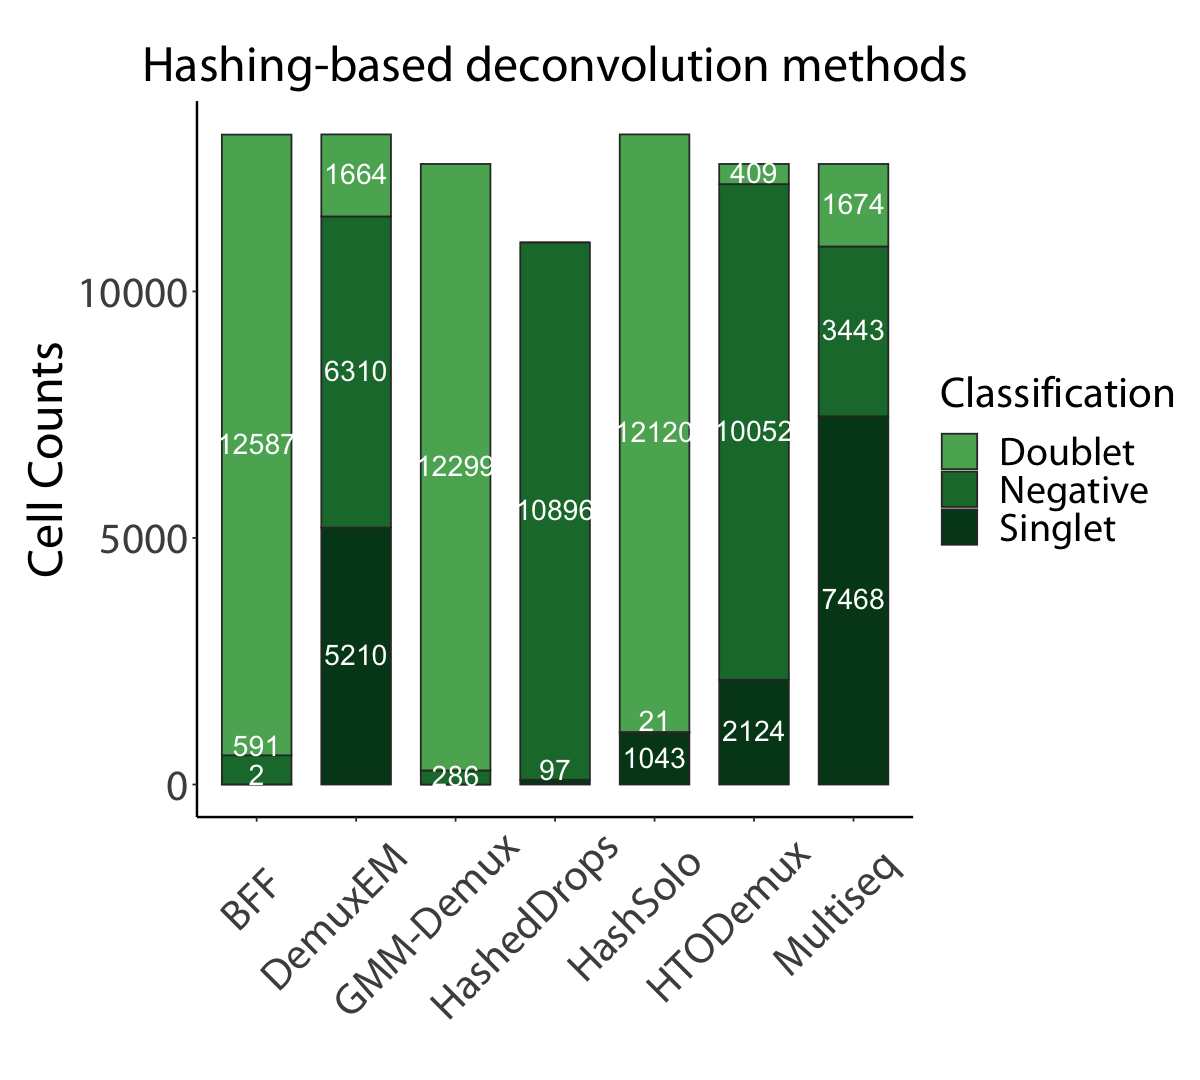

In [14]:
# Barplot
ggplot(
  summary_hash_gx38_cumsum,
  aes(x = Method, y = Count, fill = Classification)
) +
  geom_bar(
    stat = "identity",
    width = 0.7,
    color = "grey20"
  ) +
  scale_fill_manual(values = c("#5AAE61", "#1B7837", "#00441B")) +
  plot_theme() +
  xlab("") +
  ylim(0, 13200) +
  ylab("Cell Counts") +
  geom_text(
    aes(y = label_ypos, label = Count),
    vjust = 0.5,
    color = "white",
    size = 6
  ) +
  theme(axis.text.x = element_text(
    angle = 45,
    hjust = 0.7,
    vjust = 0.7
  )) +
  ggtitle("Hashing-based deconvolution methods")


## Visualisation of genetic deconvolution results


In [15]:
# Load genetic demultiplexing results
gene_gx38_classi <-
    fread("../data/pipeline_output/gx38/genetic_classification_all.csv")

# Remove the trial ID
colnames(gene_gx38_classi) <-
    c("Barcode", "Freemuxlet", "scSplit", "Souporcell", "Vireo")

# Reorder the result
summary_gene_gx38 <- melt(
    gene_gx38_classi,
    id.vars = "Barcode",
    variable.name = "Method",
    value.name = "Classification"
)
summary_gene_gx38 <- na.omit(summary_gene_gx38)
summary_gene_gx38 <- as.data.frame(table(summary_gene_gx38[, -1]))
colnames(summary_gene_gx38)[3] <- "Count"
summary_gene_gx38 <-
    summary_gene_gx38[order(summary_gene_gx38$Classification, decreasing = T), ]
head(summary_gene_gx38)


,Method,Classification,Count
,<fct>,<fct>,<int>
9,Freemuxlet,singlet,11908
10,scSplit,singlet,10604
11,Souporcell,singlet,11269
12,Vireo,singlet,10351
5,Freemuxlet,negative,17
6,scSplit,negative,0


In [16]:
# Determine the y-axis position of labels ylab_pos
summary_gene_gx38_cumsum <-
    ddply(summary_gene_gx38,
        "Method",
        transform,
        label_ypos = cumsum(Count) - 0.5 * Count + 40
    )

# Avoid showing count 0
summary_gene_gx38_cumsum[summary_gene_gx38_cumsum$Count == 0, ]$label_ypos <-
    NA

# Modify the ylab_pos manually
summary_gene_gx38_cumsum[summary_gene_gx38_cumsum$Method == "Freemuxlet" &
    summary_gene_gx38_cumsum$Classification == "negative", ]$label_ypos <-
    11500

# Rename classification
summary_gene_gx38_cumsum$Classification <-
    str_to_title(summary_gene_gx38_cumsum$Classification)


Warning message:
"Removed 1 rows containing missing values (`geom_text()`)."


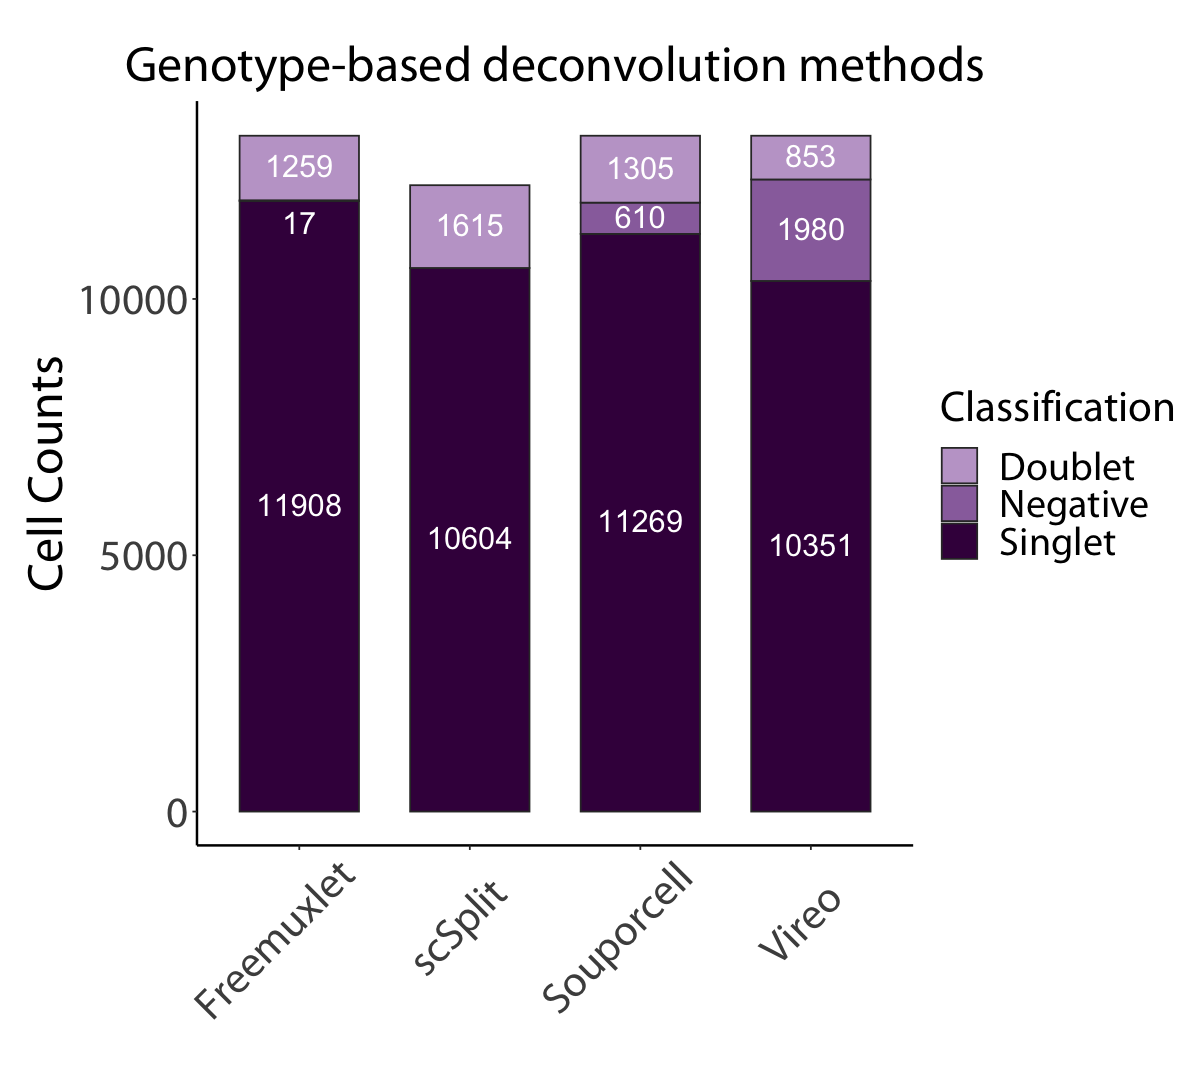

In [17]:
# Barplot
ggplot(
  summary_gene_gx38_cumsum,
  aes(x = Method, y = Count, fill = Classification)
) +
  geom_bar(
    stat = "identity",
    width = 0.7,
    colour = "grey20"
  ) +
  scale_fill_manual(values = c("#C2A5CF", "#9970AB", "#40004B")) +
  plot_theme() +
  xlab("") +
  ylim(0, 13200) +
  ylab("Cell Counts") +
  geom_text(
    aes(y = label_ypos, label = Count),
    vjust = 0.5,
    color = "white",
    size = 6.5
  ) +
  theme(axis.text.x = element_text(
    angle = 45,
    hjust = 0.7,
    vjust = 0.7
  )) +
  ggtitle("Genotype-based deconvolution methods")


In [18]:
library(cowplot)

p1 <- DimPlot(htodemux_gx38_subset, reduction = "umap") +
    scale_colour_manual(
        values = c(
            "#FFD92F",
            "#A6D854",
            "#FC8D62",
            "#6BAED6",
            "#E5C494",
            "#E78AC3",
            "#B3B3B3"
        ),
        limits = c("Doublet", paste0("Hash45", 1:6)),
        labels = c("Doublet", paste0("Hash45", 1:6))
    ) +
    plot_theme() + xlab("UMAP1") + ylab("UMAP2") + theme(
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank()
    )

p2 <- ggplot(counts_raw) +
    geom_violin(aes(x = Hashtag, y = Expression, fill = Hashtag)) +
    xlab("") +
    ylab("Raw hashtag counts") +
    scale_fill_manual(values = c(
        "#A6D854",
        "#FC8D62",
        "#6BAED6",
        "#E5C494",
        "#E78AC3",
        "#B3B3B3"
    )) +
    geom_segment(
        data = cutoff,
        inherit.aes = FALSE,
        colour = "red",
        linewidth = 0.8,
        aes(
            x = as.numeric(Hashtag) - 0.4,
            xend = as.numeric(Hashtag) + 0.4,
            yend = slope_value,
            y = slope_value
        )
    ) +
    plot_theme() +
    scale_y_log10() +
    theme(axis.text.x = element_text(
        angle = 45,
        hjust = 0.8,
        vjust = 0.7
    ))

upperplot <- align_plots(p1, p2, align = "h", axis = "bt")


In [19]:
p3 <- ggplot(
  summary_hash_gx38_cumsum,
  aes(x = Method, y = Count, fill = Classification)
) +
  geom_bar(
    stat = "identity",
    width = 0.7,
    color = "grey20"
  ) +
  scale_fill_manual(values = c("#5AAE61", "#1B7837", "#00441B")) +
  plot_theme() +
  xlab("") +
  ylim(0, 13200) +
  ylab("Cell Counts") +
  geom_text(
    aes(y = label_ypos, label = Count),
    vjust = 0.5,
    color = "white",
    size = 6
  ) +
  theme(axis.text.x = element_text(
    angle = 45,
    hjust = 0.7,
    vjust = 0.7
  )) +
  ggtitle("Hashing-based deconvolution methods")

p4 <- ggplot(
  summary_gene_gx38_cumsum,
  aes(x = Method, y = Count, fill = Classification)
) +
  geom_bar(
    stat = "identity",
    width = 0.7,
    colour = "grey20"
  ) +
  scale_fill_manual(values = c("#C2A5CF", "#9970AB", "#40004B")) +
  plot_theme() +
  xlab("") +
  ylim(0, 13200) +
  ylab("Cell Counts") +
  geom_text(
    aes(y = label_ypos, label = Count),
    vjust = 0.5,
    color = "white",
    size = 6.5
  ) +
  theme(axis.text.x = element_text(
    angle = 45,
    hjust = 0.7,
    vjust = 0.7
  )) +
  ggtitle("Genotype-based deconvolution methods")

barplot <- align_plots(p3, p4, align = "h")


Warning message:
"Removed 2 rows containing missing values (`geom_text()`)."
Warning message:
"Removed 1 rows containing missing values (`geom_text()`)."
